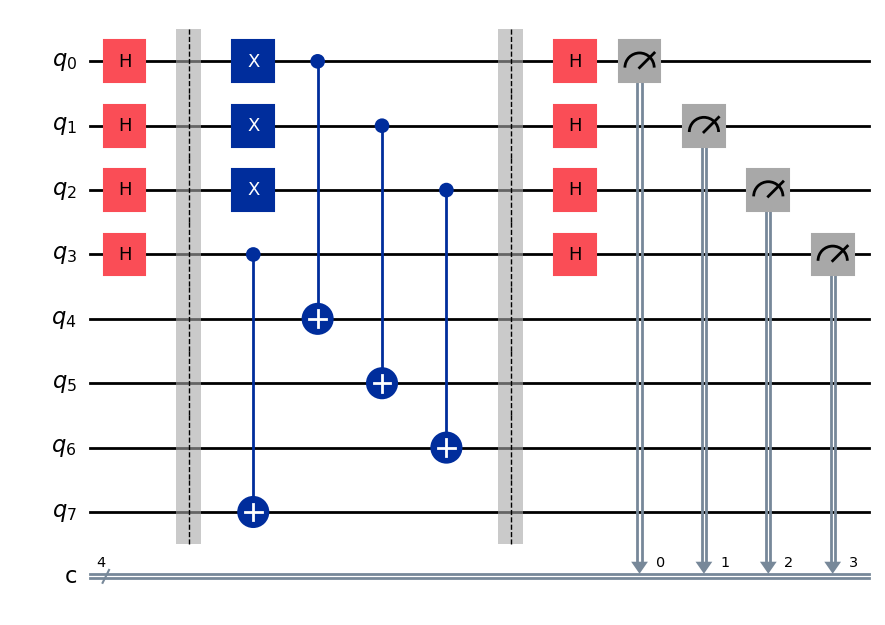

In [ ]:
import numpy as np
from numpy import pi
import math
import matplotlib.pyplot as plt
# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram


def one_to_one_oracle(qc, s, n):
    for i in range(n):
        if np.random.rand() > 0.5:
            qc.x(i)
    for i in range(n):
        qc.cx(i, i + n)
            
def two_to_one_oracle(qc, s, n):
    flag = 0
    for i, si in enumerate(reversed(s)):
        qc.cx(i, i + n)
        if si == '1' and flag == 0:
            qc.x(i)
            for j, sj in enumerate(reversed(s)):
                if sj == '1':
                    qc.cx(i, j + n)
            qc.x(i)
            flag = 1

########################
#### アルゴリズムの本体
########################
'''
Simonのアルゴリズムの流れ
初期状態の準備: 入力レジスタに Hadamardゲートを適用し、全状態の重ね合わせを作る。
オラクルの適用: 1対1または2対1の写像（ここではランダムに選択）を実装したオラクルを適用する。
干渉の発生: 再び Hadamardゲートを適用することで、2対1の場合は隠れた周期 s に関する情報（𝑦⋅𝑠=0 の条件）が測定結果に現れる。
測定と古典後処理: 入力レジスタを測定し、得られた複数のビット列から線形方程式を解いて秘密文字列 s を特定する。
'''

# 入力レジスタに4量子ビット、出力レジスタにも4量子ビット、合計8量子ビットを用います。
n = 4
# 秘密文字列 s
# 1から 2𝑛−1の間でランダムな整数 N を選び、それを2進数文字列（長さが4桁）に変換して秘密文字列 s としています（全ゼロは除外）。
N = np.random.randint(1, 2**n-1)
s = bin(N)[2:].zfill(n)
# 量子ビットと古典ビットの配置
#   - 量子ビット: 2n個。最初の 4 ビット（インプットレジスタ）、後半の 4 ビット（出力レジスタ）。
#   - 古典ビット: n個。測定結果を格納するための 4 ビット（入力レジスタの結果を読み出す）。
qc = QuantumCircuit(n * 2, n)

# Hゲートを各量子ビットに適用
for i in range(n):
    qc.h(i)

qc.barrier()

# オラクルの選択
if np.random.rand() > 0.5:
    two_to_one_oracle(qc, s, n)
    selected = 'two_to_one'
else:
    one_to_one_oracle(qc, s, n)
    selected = 'one_to_one'

qc.barrier()

# 再度Hゲートを適用
for i in range(n):
    qc.h(i)

# 測定
for i in range(n):
    qc.measure(i, i)
    
qc.draw(output='mpl')


one_to_one
s = 1010


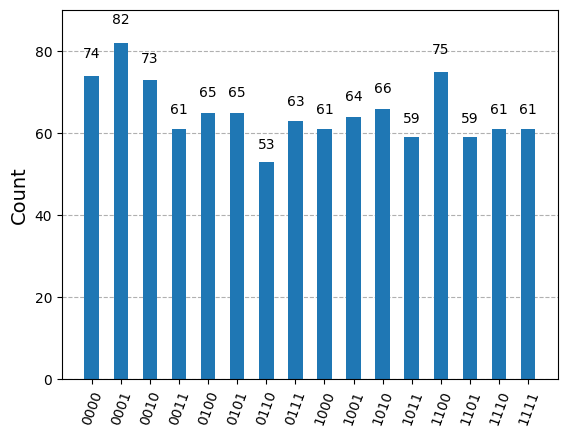

In [8]:

# AerSimulatorを使用して実行
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1042).result()

# 結果を取得して表示
answer = result.get_counts()
print(selected)
print('s =', s)
plot_histogram(answer)


In [5]:

# オラクルのみからなる量子回路に |s> を入力
qc = QuantumCircuit(n * 2, n)

for i, si in enumerate(reversed(s)):
    if si == '1':
        qc.x(i)

two_to_one_oracle(qc, s, n)

for i in range(n):
    qc.measure(i + n, i)
    
# AerSimulatorを使用して実行
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=128).result()

# 結果を取得して表示
answer = result.get_counts()
print(answer)


{'1011': 128}


In [6]:

# オラクルのみからなる量子回路に |0> を入力
qc = QuantumCircuit(n * 2, n)

two_to_one_oracle(qc, s, n)

for i in range(n):
    qc.measure(i + n, i)
    
# AerSimulatorを使用して実行
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=128).result()

# 結果を取得して表示
answer = result.get_counts()
print(answer)


{'1011': 128}
